# Introduction

Ocean is indispensible to both the ecosystem and human society. It plays a significant role in not only climate regulation and carbon sequestration, but also providing sources of protein to the food chain. Humans, especially those who live in coastal areas, largely rely on the ocean for food. However, due to overfishing, pollution, and other factors, many seafood stocks are at the brink of collapse. A study conducted by Worm et al. ([DOI: 10.1126/science.1132294](https://pubmed.ncbi.nlm.nih.gov/17082450/)), published on *Science*, predicts that most seafood fisheries will collapse by 2050.

Overfishing and by-catches are the two unsustainable fishing practices that threatens the marine ecosystem. In tuna fisheries, overfishing and by-catches are results of illegal, unregulated and unreported catches, which are common in the Western and Central Pacific, according to the Nature Conservancy. On the high seas, monitoring and enforcing legal practices can be difficult due to the remoteness of the location, and the cumbersome amount of raw data (images and videos recorded by fishing ship cameras) to be processed and analyzed manually.

In the following, a possible solution is provided to address this issue. A Convoluted Neural Network (CNN) model is designed and implemented to predict and classify the species of catches from a set of 8 classes, based on the images recorded by monitoring cameras on fishing ships. This will automate and thus significantly accelerate the reviewing process. 

In particular, two CNN models, one using an Adam optimizer and the other using a customized stochastic gradient descent (SGD) optimizer, are implemented and their performances are compared. It is concluded that the model using the Adam optimizer out-performs the model using customized SGD optimizer, achieving a logloss of 0.49 and an accuracy of 92% on the validating dataset.

The dataset is provided by the Nature Conservancy, which contains 8 classes of images with a resolution of 1280x720 pixels, sorted in their class folders, respectively. The 8 classes are Albacore tuna (ALB, *Thunnus alalunga*), Bigeye tuna (BET, *Thunnus obesus*), Dolphinfish/Mahi Mahi (DOL, *Coryphaena hippurus*), Opah/Moonfish (LAG, *Lampris guttatus*), Sharks (SHARK, various species), Yellowfin tuna (YFT, *Thunnus albacares*), other species (OTHER), and no-fish (NoF). More information can be found [here](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/data).

# Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fishCategories = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Read in the training images using CV2. Each data point (image) is first down-sampled from 1280x720 pixels to 480x270 pixels, then converted to numpy unsigned integers (0-255). 

In [2]:
import cv2
import os
import glob

def readImg(path):
    img = cv2.imread(path)
    img = cv2.resize(img, dsize=(480, 270), interpolation=cv2.INTER_CUBIC)
    return img

imagePaths = [] # X
yLabels = []    # y

# Read in image paths and labels, set up y
for fish in fishCategories:
    src = os.path.join('./Dataset/train', fish, '*.jpg')
    fishImgs = glob.glob(src)
    
    imagePaths.extend(fishImgs)
    yLabels.extend(np.tile(fish, len(fishImgs)))
    
    
#  set up X by down-sampling and converting datapoints to unsigned-ints.
X = np.ndarray((len(imagePaths), 270, 480, 3), dtype=np.uint8)

print('Started Loading...')

for idx, path in enumerate(imagePaths):
    X[idx] = readImg(path)
    if ((idx % 1000) == 0):
        print ("Loaded {0} images".format(idx))
        
print('Finished Loading.')

Started Loading...
Loaded 0 images
Loaded 1000 images
Loaded 2000 images
Loaded 3000 images
Finished Loading.


# CNN

Split the dataset into training and validating datasets. Also, the labels/classes to be predicted is one-hot encoded into binary.

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

y = np.array(yLabels)
y = LabelEncoder().fit_transform(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101, test_size=0.23, stratify=y)

### Adam

Setup the CNN model. 

All input data is first normalized and converted to float 32 by the activation layer, followed by 3 groups of convolution layers (with zero-padding) and max-pooling layers to extract features. Note that the filter size is first set to 36 then to 72 for a gradual learning process, considering that the fish to be categorized are located in a specific portion of the image. This is also the reason for kernel size to be set to 5x5 first, then reset to 3x3.

Finally, the matrix is flattened and the data are further passed through densely-connnected layers for feature learning, and finally passed through a layer of 8 perceptrons for output using a softmax activating function.

For model compilation, the Adam optimizer is attempted first as it is a gradient-based optimization of stochastic functions, thus including the advantage of both RMSprop and AdaGrad optimizers. However, in recent studies such as the one conducted by Nitish Shirish Keskar and Richard Socher from Cornell University ([arXiv:1712.07628](https://arxiv.org/abs/1712.07628)) *Improving Generalization Performance by Switching from Adam to SGD*, it is shown that in certain scenarios, Adam may not converge well to the global min. Therefore, an SGD optimizer will be attempted afterwards.

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout, Activation, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from keras.backend import mean, std

def normalizeData(data):
    return (data - backend.mean(data)) / backend.std(data)

cnnModel = Sequential([
    
    # Normalize data, convert uint8 to float32.
    Activation(activation=lambda x: (x - mean(x)) / std(x), input_shape=(270, 480, 3)),
    
    # Start with 36 filters to learn features. Kernel size is set to 5x5 to learn general features. 
    # Added zero padding.
    # 3@360x640 -> 5x5 -> 3x36@356x636 -> 2x2 -> 3x36@178x318
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Second iteration, with 72 filters to learn more features. Kernel size set to 3x3 to learn the details
    # of the pooling. Added zero padding.
    # 3x36@178x318 -> 3x3 -> 3x72@176x316 -> 2x2 -> 3x72@88x158
    Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Last iteration, with 144 filters to learn more features. Kernel size set to 3x3 to learn the details of
    # the pooling. Added zero padding.
    # 3x72@88x158 -> 3x3 -> 3x144@86x156 -> 2x2 -> 3x144@43x78
    Conv2D(filters=144, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=144, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Flatten
    Flatten(),
    
    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(32, activation='relu'),
    Dropout(0.5),
    
    # Outputs
    Dense(8, activation='softmax')
])

# Compile the model using Adam optimizer. 
cnnModel.compile(optimizer=Adam(learning_rate=1e-3), 
                 loss='categorical_crossentropy', 
                 metrics=['accuracy'])

Using TensorFlow backend.


Fit the data to the training dataset.

The number of epochs is set to 24 with an early stopping mechanism. 

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=3)
cnnModel.fit(x = X_train, 
             y = y_train, 
             validation_data=(X_test, y_test),
             batch_size = 64, 
             epochs=24,
             verbose = 1,
             shuffle=True,
             callbacks = [earlyStop])

Epoch 1/24
46/46 [==============================] - 1036s 23s/step - loss: 2.6321 - accuracy: 0.3669 - val_loss: 1.5322 - val_accuracy: 0.5213
Epoch 2/24
46/46 [==============================] - 1060s 23s/step - loss: 1.6199 - accuracy: 0.4584 - val_loss: 1.2851 - val_accuracy: 0.5512
Epoch 3/24
46/46 [==============================] - 1016s 22s/step - loss: 1.3834 - accuracy: 0.5155 - val_loss: 1.0488 - val_accuracy: 0.6168
Epoch 4/24
46/46 [==============================] - 1032s 22s/step - loss: 1.1605 - accuracy: 0.5942 - val_loss: 0.8557 - val_accuracy: 0.7043
Epoch 5/24
46/46 [==============================] - 1039s 23s/step - loss: 0.9605 - accuracy: 0.6623 - val_loss: 0.6686 - val_accuracy: 0.7929
Epoch 6/24
46/46 [==============================] - 1033s 22s/step - loss: 0.7728 - accuracy: 0.7314 - val_loss: 0.5168 - val_accuracy: 0.8493
Epoch 7/24
46/46 [==============================] - 1037s 23s/step - loss: 0.6414 - accuracy: 0.7706 - val_loss: 0.4788 - val_accuracy: 0.8688

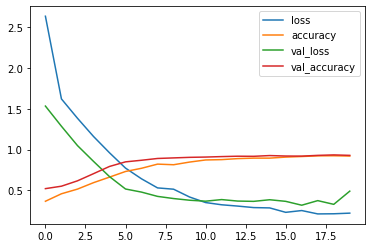

In [6]:
modelLoss = pd.DataFrame(cnnModel.history.history)
modelLoss.plot()

The training time is approximately 5.5 hours. It can be observed from the log and the plot above that loss and val_loss decreased over-epochs and for val_loss, it converged to approximately 0.35-0.45. The accuracy converged to approximately 92% based on the validating dataset.

In the following, the model is used to predict and classify datapoints in the validating dataset.

In [7]:
prediction = cnnModel.predict(X_test, verbose=1)

28/28 [==============================] - 71s 3s/step


In [8]:
prediction

array([[3.9007995e-05, 3.3702458e-06, 9.7945323e-09, ..., 9.9995708e-01,
        8.9519572e-12, 1.3330062e-07],
       [1.0000000e+00, 5.2846433e-25, 3.3916260e-38, ..., 2.1760551e-26,
        8.4069531e-37, 6.0294374e-30],
       [1.0000000e+00, 1.2790670e-17, 1.6963766e-25, ..., 2.9645721e-19,
        5.5418908e-26, 2.1380541e-21],
       ...,
       [9.9999630e-01, 5.3540457e-08, 1.0733866e-10, ..., 3.4452833e-06,
        1.0591284e-10, 3.9448034e-10],
       [7.3098035e-14, 2.8448615e-20, 1.2518587e-13, ..., 2.0503368e-19,
        5.5473337e-16, 1.0000000e+00],
       [6.6139919e-01, 4.3387558e-02, 2.1890325e-02, ..., 3.0278634e-02,
        3.0356750e-02, 3.6489565e-02]], dtype=float32)

In [9]:
from sklearn.metrics import log_loss
print(log_loss(y_test, prediction))

0.4935223864956434


Given the definition $L(p_{i})=-\log{p_{i}}$, a logloss of approximately 0.5 means that the right class is attributed to a probability of $e^{-0.5} = 0.607$ in average, which is quite high considering this is a multi-class classification problem with 8 classes. Note that the accuracy of the model is approxiamtely 92% when the training finished.

Save the model.

In [11]:
cnnModel.save('cnnAdamFishMonitoring.h5')

### SGD

SGD gradient-descents on a small subset/random selected data examples. Many advantages of SGD include lower demand of memory (non-parallel), faster training computations, frequent updates of weights, etc. 

In the following, another CNN model is first setup to have an identical design as the first model.

In [36]:
cnnModel2 = Sequential([
    
    # Normalize data, convert uint8 to float32.
    Activation(activation=lambda x: (x - mean(x)) / std(x), input_shape=(270, 480, 3)),
    
    # Start with 36 filters to learn features. Kernel size is set to 5x5 to learn general features. 
    # Added zero padding.
    # 3@360x640 -> 5x5 -> 3x36@356x636 -> 2x2 -> 3x36@178x318
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=36, kernel_size=(5, 5), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Second iteration, with 72 filters to learn more features. Kernel size set to 3x3 to learn the details
    # of the pooling. Added zero padding.
    # 3x36@178x318 -> 3x3 -> 3x72@176x316 -> 2x2 -> 3x72@88x158
    Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=72, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Last iteration, with 144 filters to learn more features. Kernel size set to 3x3 to learn the details of
    # the pooling. Added zero padding.
    # 3x72@88x158 -> 3x3 -> 3x144@86x156 -> 2x2 -> 3x144@43x78
    Conv2D(filters=144, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    Conv2D(filters=144, kernel_size=(3, 3), activation='relu', padding='same', data_format="channels_last"),
    MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', data_format="channels_last"),
    
    # Flatten
    Flatten(),
    
    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(32, activation='relu'),
    Dropout(0.5),
    
    # Outputs
    Dense(8, activation='softmax')
])

Next, a customized SGD optimizer is attempted. However, it is necessary to re-do train-test-split because the customized fit/train configuration accepts original categorical data only, without one-hot encoding.

In [50]:
y2 = np.array(yLabels)
y2 = LabelEncoder().fit_transform(y2)
y2 = to_categorical(y2).astype(np.int64)

X_train2, X_test2, y_train, y_test2 = train_test_split(X, y2, random_state=101, test_size=0.23, stratify=y2)

# convert to categorical data only.
y_train2 = []
for row in y_train:
    for idx, e in enumerate(row):
        if (e != 0):
            y_train2.append(idx)
            break

Customize the training process. 

The data is iterated through EPOCH number of times, and the training dataset is divided in batches of BATCHSIZE images. The EPOCH and BATCHSIZE amounts are unchanged from the first model, remaining at 24 and 64, respectively.

For each batch, images are first converted to float32 tensors, then GradientTape from tensorflow library is used to record differentiation operations. Afterwards, the sparse categorical crossentropy loss is computed and used to further compute the gradient in order to backpropagate. Eventually, the weights are updated, and the iteration restarts.

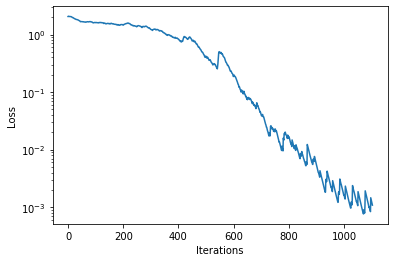


100%|██████████| 24/24 [8:51:46<00:00, 1329.44s/it]


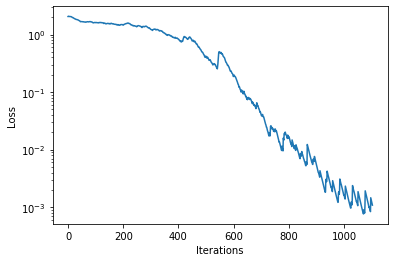

In [38]:
from tqdm import tqdm
import mitdeeplearning as mdl
from tensorflow import convert_to_tensor, float32, GradientTape
from keras.backend import sparse_categorical_crossentropy as scc
from tensorflow.keras.optimizers import SGD

BATCHSIZE = 64
EPOCHS = 24
loss_record = mdl.util.LossHistory(smoothing_factor=0.95)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
opt = SGD(learning_rate=0.001)

# Pass data using EPOCHS number of times
if hasattr(tqdm, '_instances'): tqdm._instances.clear()
for epoch in tqdm(range(0, EPOCHS, 1)):
    
    # Feed in input images in groups of batch size
    for idx in tqdm(range(0, X_train2.shape[0], BATCHSIZE)):

        # Convert images to tensors
        imgs = X_train2[idx: idx+BATCHSIZE]
        labels = y_train2[idx: idx+BATCHSIZE]
        X_tensors = convert_to_tensor(imgs, dtype=float32)

        # Record differentiations using gradientTape and plot it.
        with GradientTape() as t:
            logits = cnnModel2(X_tensors) 
            loss = scc(labels, logits)
        loss_record.append(loss.numpy().mean())
        plotter.plot(loss_record.get())

        # backpropagation by computing gradient 
        gradients = t.gradient(loss, cnnModel2.trainable_variables)
        opt.apply_gradients(zip(gradients, cnnModel2.trainable_variables))
    

The training time is around 9 hours. 

Save the model.

In [42]:
cnnModel2.save('cnnSGDCustomFishMonitoring.h5')

The model is used to further predict the validation dataset.

In [51]:
prediction2 = cnnModel2.predict(X_test)

prediction2

array([[1.18553689e-09, 2.89358704e-21, 8.93819209e-17, ...,
        1.00000000e+00, 8.46492308e-34, 5.65555091e-26],
       [9.99999046e-01, 1.06580396e-11, 1.10967997e-15, ...,
        4.65004518e-07, 1.86802088e-10, 3.76406371e-12],
       [1.00000000e+00, 3.71761602e-17, 7.88584853e-25, ...,
        1.81773626e-14, 1.14520080e-19, 1.50676238e-12],
       ...,
       [1.00000000e+00, 4.76608995e-17, 1.83101615e-20, ...,
        8.42761017e-12, 2.34918638e-22, 1.03645109e-12],
       [1.31596028e-30, 1.64667218e-15, 1.91907732e-14, ...,
        5.45937468e-15, 3.06911574e-26, 1.00000000e+00],
       [9.99999046e-01, 4.28724070e-12, 6.28883393e-13, ...,
        6.34961168e-07, 4.55640103e-09, 6.22132845e-10]], dtype=float32)

In [52]:
print(log_loss(y_test2, prediction2))

0.5575856430750982


The prediction from the second model has a logloss of 0.557585, which indicates that the right class is attributed to a probability of $e^{-0.557} = 0.573$ in average, which is still quite high considering this is a multi-class classification problem with 8 classes, but lower than the average probability (60.7%) predicted by the first model. Thus, the Adam optimizer out-performs this customized SGD optimizer.

### Predicting an unseen datapoint

Use the first CNN model to predict an unseen datapoint. The image is an albacore Tuna. Note the discretion of graphic contents.

In [59]:
img = cv2.imread('./singleData.jpg')
img = cv2.resize(img, dsize=(480, 270), interpolation=cv2.INTER_CUBIC)

df = np.ndarray((1, 270, 480, 3), dtype=np.uint8)
df[0] = img
cnnModel.predict(df)

array([[9.9999964e-01, 1.5728621e-07, 1.1778742e-11, 4.9943588e-10,
        2.0078964e-08, 1.6108788e-07, 1.8277022e-11, 4.6236456e-10]],
      dtype=float32)

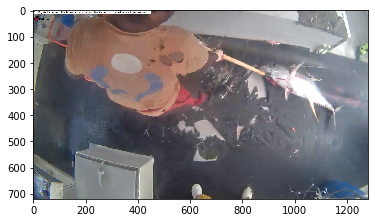

In [60]:
import matplotlib.image as mpimg
img=mpimg.imread('./singleData.jpg')
imgplot = plt.imshow(img)
plt.show()

Note that the model assigns the albacore tuna class a probability of approximately 1, thus correctly predicting that the image contains an albacore tuna.

# Conclusion

Illegal, unreported, and unregulated fisheries can be devastating to fish stocks and thus aggrevate the current trend of overfishing and extinction. Computer Vision and ML algorithms can provide an efficient and effective approach to monitor and enforce legal and sustainable fisheries on the high seas by automating the classification process of fish species based on images collected by the cameras on the fishing ships, and thus accelerating the video reviewing process. In this project, two CNN models, one using Adam optimizer and the other using SGD optimizer, are implemented and trained on a dataset of 3000+ images. It is shown that the Adam optimizer is more accurate than the SGD optimizer. Overall, the CNN model with Adam optimizer achieves an accuracy of 92% and a logloss of 0.494, thus assigning the correct fish species class with a probability of 60.7% in average. It is concluded that the approach of identifying and classifiying fish species using CNN and Computer Vision is plausible and effective, and with larger dataset and more training, models can be developed to support fishery regulatory procedures by the Government or charitable organizations such as the Nature Conservancy.